# Kaggle Project: Invasive Species Monitoring (Playground)

[Project Page](https://www.kaggle.com/c/invasive-species-monitoring) 

The data set contains pictures taken in a Brazilian national forest. In some of the pictures there is Hydrangea, a beautiful invasive species original of Asia. Based on the training pictures and the labels provided, the participant should predict the presence of the invasive species in the testing set of pictures.

## File descriptions

* train.7z - the training set (contains 2295 images).
* train_labels.csv - the correct labels for the training set.
* test.7z - the testing set (contains 1531 images), ready to be labeled by your algorithm.
* sample_submission.csv - a sample submission file in the correct format.

## Data fields

name - name of the sample picture file (numbers)
invasive - probability of the picture containing an invasive species. A probability of 1 means the species is present.

In [15]:
import math
from glob import glob
import os
import random
from os import listdir
from os.path import isfile, join
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sklearn
import scipy

from sklearn.model_selection import train_test_split

%matplotlib inline



# Import Keras

from keras.models import Sequential, Model, load_model
from keras import applications
from keras import optimizers
from keras.callbacks import ModelCheckpoint
from keras.layers import Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [ ]:
# Make input data directory
!mkdir input

# 1. Download data (via shell)

1. Download data via [kaggle-cli](https://github.com/floydwch/kaggle-cli); requires username and password
2. Extract with 7za and unzip into input
3. Extracted data
   * train data: ./input/train
   * test data: ./input/test
   * train labels: ./input/train_labels.csv




# 2. Preview data labels and train/ test images

In [4]:
# Read train label data
train_labels = pd.read_csv("./input/train_labels.csv")
print("Number of training examples:{}".format(len(train_labels)))
train_labels.head()

Number of training examples:2295


,name,invasive
0,1,0
1,2,0
2,3,1
3,4,0
4,5,1


In [46]:
# Split Train data into train and validation

train_set, val_set = train_test_split(train_labels, test_size = 0.1)

print("Train data size: {}".format(len(train_set)))
print("Validation data size: {}".format(len(val_set)))


Train data size: 2065
Validation data size: 230


In [54]:
# Set parameters
TRAIN_DIR = './input/train/'
TEST_DIR = './input/test/'
nb_epoch = 50
# dimensions of our target images.
img_height, img_width, img_channel = 244, 244, 3

In [55]:
# Create train filepaths + targets
y_train = []
train_file_paths = []
for i in range(len(train_set)):
    train_file_paths.append( TRAIN_DIR + str(train_set.iloc[i][0]) +'.jpg' )
    y_train.append(train_set.iloc[i][1])
y_train = np.array(y_train)

# Create validation filepaths + targets
y_val = []
val_file_paths = []
for i in range(len(val_set)):
    val_file_paths.append( TRAIN_DIR + str(val_set.iloc[i][0]) +'.jpg' )
    y_val.append(val_set.iloc[i][1])
y_val = np.array(y_val)

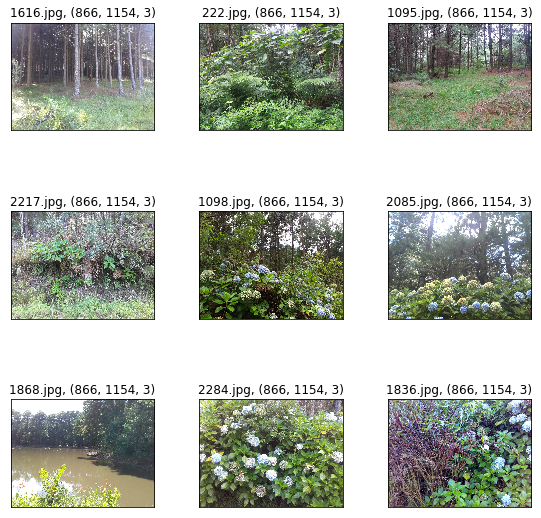

In [49]:
# Preview train images

fig, axes = plt.subplots(figsize=(8, 8), nrows=3, ncols=3)
plt.tight_layout() # Increases space between subplots

# Randomly select and display 9 images
for ax in axes.flat:
    file_path = random.choice(train_file_paths)
    img=mpimg.imread(file_path)
    ax.imshow(img)
    ax.set_title("{}, {}".format(os.path.basename(file_path), img.shape))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

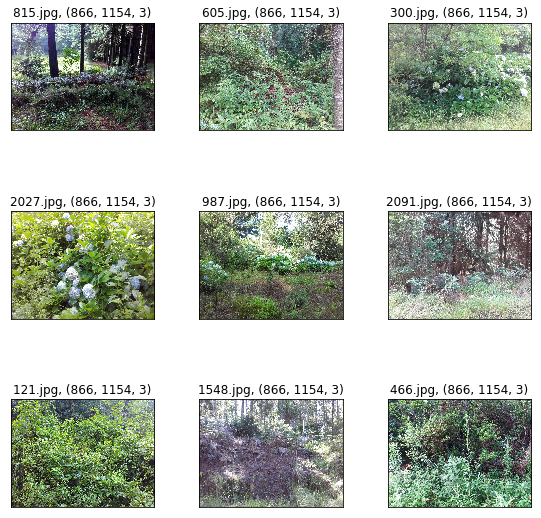

In [50]:
# Preview validation images

fig, axes = plt.subplots(figsize=(8, 8), nrows=3, ncols=3)
plt.tight_layout() # Increases space between subplots

# Randomly select and display 9 images
for ax in axes.flat:
    file_path = random.choice(val_file_paths)
    img=mpimg.imread(file_path)
    ax.imshow(img)
    ax.set_title("{}, {}".format(os.path.basename(file_path), img.shape))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

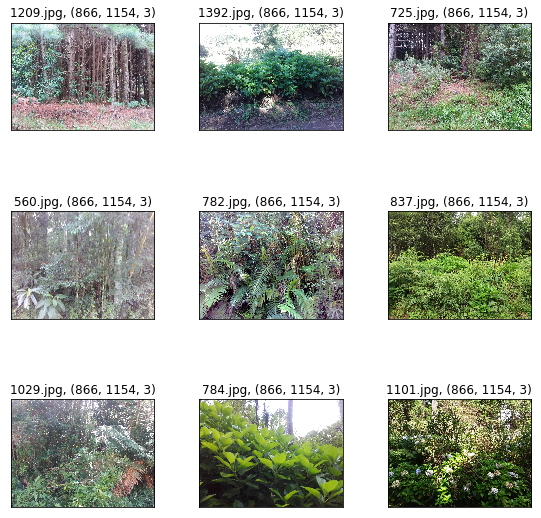

In [51]:
# Read file paths for test images

test_file_paths = [os.path.join(TEST_DIR, f) for f in listdir(TEST_DIR) if isfile(join(TEST_DIR, f))]
# test_file_ids = [os.path.splitext(os.path.basename(path))[0] for path in test_file_paths]

# Preview train images

fig, axes = plt.subplots(figsize=(8, 8), nrows=3, ncols=3)
plt.tight_layout() # Increases space between subplots

# Randomly select and display 9 images
for ax in axes.flat:
    file_path = random.choice(test_file_paths)
    img=mpimg.imread(file_path)
    ax.imshow(img)
    ax.set_title("{}, {}".format(os.path.basename(file_path), img.shape))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    

In [56]:
# Read and store train, val, and test data into numpy arrays

# Resize images to consistent shape
new_shape = (img_height, img_width)

# Read train img files
train_img = []
with tqdm(total=len(train_file_paths)) as pbar:
    for ix, file_path in enumerate(train_file_paths):
        img = load_img(file_path) 
        x = img_to_array(img) # Turn into numpy array
        x_resized = scipy.misc.imresize(x, new_shape)
        train_img.append(x_resized)
        pbar.update()
    train_img = np.stack(train_img)
    print("Finished reading train images")
    
# Read validation img files
val_img = []
with tqdm(total=len(val_file_paths)) as pbar:
    for ix, file_path in enumerate(val_file_paths):
        img = load_img(file_path) 
        x = img_to_array(img) # Turn into numpy array
        x_resized = scipy.misc.imresize(x, new_shape)
        val_img.append(x_resized)
        pbar.update()
    val_img = np.stack(val_img)
    print("Finished reading validation images")

# Read test img files
test_img = []
with tqdm(total=len(test_file_paths)) as pbar:
    for ix, file_path in enumerate(test_file_paths):
        img = load_img(file_path) 
        x = img_to_array(img) # Turn into numpy array
        x_resized = scipy.misc.imresize(x, new_shape)
        test_img.append(x_resized)
        pbar.update()
    test_img = np.stack(test_img)
    print("Finished reading test images")





  1%|          | 2/230 [00:00<00:11, 19.33it/s]

Finished reading train images


  0%|          | 3/1531 [00:00<01:15, 20.28it/s]

Finished reading validation images


100%|██████████| 1531/1531 [01:20<00:00, 19.09it/s]

Finished reading test images


In [57]:
# Save np.arrays for later use
outfile = './input/data_compressed.npz'

np.savez_compressed(outfile, train_img=train_img, y_train=y_train, val_img=val_img, y_val=y_val, test_img=test_img)

In [71]:
# Reload data
data = np.load('./input/data_compressed.npz')

train_img = data['train_img']
val_img = data['val_img']
test_img = data['test_img']
y_train = data['y_train']
y_val = data['y_val']



In [72]:
# Show shape of the image arrays
print("train_img shape: {}".format(train_img.shape))
print("val_img shape: {}".format(val_img.shape))
print("test_img shape: {}".format(test_img.shape))
print("y_train shape: {}".format(y_train.shape))
print("y_val shape: {}".format(y_val.shape))

train_img shape: (2065, 244, 244, 3)
val_img shape: (230, 244, 244, 3)
test_img shape: (1531, 244, 244, 3)
y_train shape: (2065,)
y_val shape: (230,)


In [73]:
# Rescale iamges

train_img = train_img.astype(float) / 255.0
val_img = val_img.astype(float) / 255.0
test_img = test_img.astype(float) / 255.0

In [78]:
# Setup the model using VGG16 


base_model = applications.VGG16(weights='imagenet', include_top=False, 
                                input_shape=(img_height, img_width, img_channel))

# Freeze the base model's layers from training
for layer in base_model.layers:
    layer.trainable = False



In [80]:
add_model = Sequential()
add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
add_model.add(Dense(256, activation='relu'))
add_model.add(Dropout(0.5))
add_model.add(Dense(1, activation='sigmoid'))

model = Model(inputs=base_model.input, outputs=add_model(base_model.output))
model.compile(loss='binary_crossentropy', 
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 244, 244, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 244, 244, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 244, 244, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 122, 122, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 122, 122, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 122, 122, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 61, 61, 128)       0         
__________

In [81]:
# Setup datagen
batch_size = 32
epochs = 50

datagen = ImageDataGenerator(
    featurewise_center=True,
    rotation_range=30, 
    width_shift_range=0.1,
    height_shift_range=0.1, 
    horizontal_flip=True)



# Fit the generators
datagen.fit(train_img)


# Fit the model 
model.fit_generator(datagen.flow(train_img, y_train, batch_size=batch_size),
                    steps_per_epoch=train_img.shape[0] // batch_size, epochs=epochs,
                    validation_data=(val_img, y_val),
                    callbacks=[ModelCheckpoint('VGG16-transferlearning.model', monitor='val_acc', save_best_only=True)]
                   )






Epoch 1/50
 7/64 [==>...........................] - ETA: 47s - loss: 0.9400 - acc: 0.4911

KeyboardInterrupt: 

# Predict test data

In [ ]:

# Rescale test img
test_img = test_img / 255.0

